Shape of the samples: torch.Size([1000, 2]) torch.Size([1000, 2])
Shape of the pairs: torch.Size([1000, 2, 2])


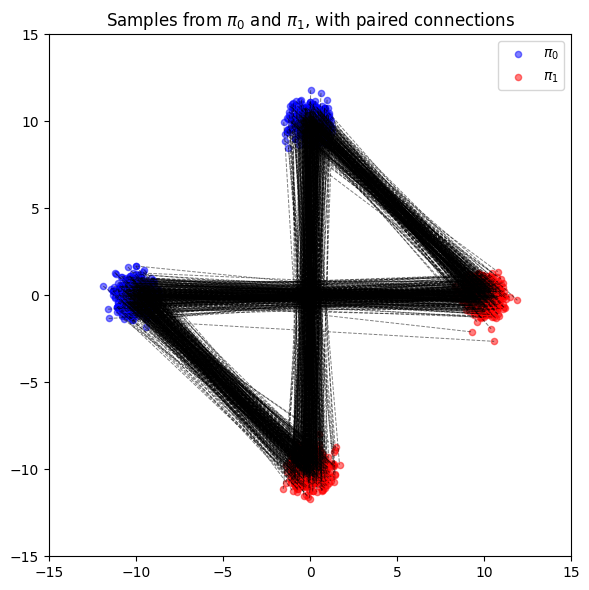

In [24]:
import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
import matplotlib.pyplot as plt
import torch.nn.functional as F


# Parameters for distributions
VAR = 0.3
COMP = 2  # Number of components

# Define initial distribution pi_0 centered at (-10, 0) and (0, 10)
initial_mix = torch.distributions.Categorical(torch.tensor([1/COMP for _ in range(COMP)]))
initial_comp = torch.distributions.MultivariateNormal(torch.tensor([[-10.0, 0.0], [0.0, 10.0]]), 
                                  VAR * torch.stack([torch.eye(2) for _ in range(COMP)]))
initial_model = torch.distributions.MixtureSameFamily(initial_mix, initial_comp)
samples_0 = initial_model.sample([1000])

# Define target distribution pi_1 centered at (0, -10) and (10, 0)
target_mix = torch.distributions.Categorical(torch.tensor([1/COMP for _ in range(COMP)]))
target_comp = torch.distributions.MultivariateNormal(torch.tensor([[0.0, -10.0], [10.0, 0.0]]), 
                                 VAR * torch.stack([torch.eye(2) for _ in range(COMP)]))
target_model = torch.distributions.MixtureSameFamily(target_mix, target_comp)
samples_1 = target_model.sample([1000])

# Shuffle and create pairs of points
x_0 = samples_0.detach().clone()[torch.randperm(len(samples_0))]
x_1 = samples_1.detach().clone()[torch.randperm(len(samples_1))]
x_pairs = torch.stack([x_0, x_1], dim=1)

# Print the shape of the samples and pairs
print('Shape of the samples:', samples_0.shape, samples_1.shape)
print('Shape of the pairs:', x_pairs.shape)

# Plot samples with pairs connected by dashed lines
plt.figure(figsize=(6, 6))
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.title(r'Samples from $\pi_0$ and $\pi_1$, with paired connections')

# Plot initial distribution points
plt.scatter(samples_0[:, 0].cpu().numpy(), samples_0[:, 1].cpu().numpy(), alpha=0.5, color='blue', label=r'$\pi_0$', s=20)

# Plot target distribution points
plt.scatter(samples_1[:, 0].cpu().numpy(), samples_1[:, 1].cpu().numpy(), alpha=0.5, color='red', label=r'$\pi_1$', s=20)

# Plot pairs connected by dashed lines
for pair in x_pairs:
    plt.plot([pair[0, 0], pair[1, 0]], [pair[0, 1], pair[1, 1]], 'k--', linewidth=0.7, alpha=0.5)

# Show the legend and plot
plt.legend()
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Training Loss Curve')

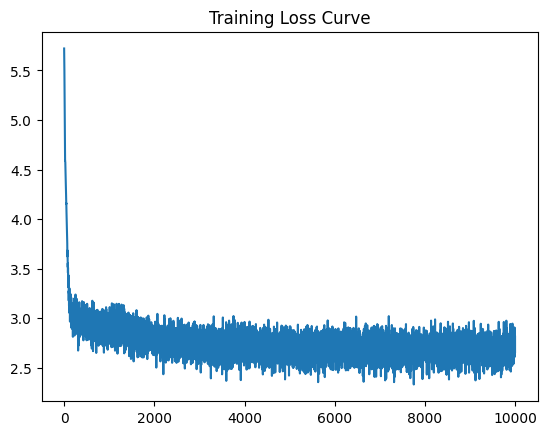

In [25]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_num=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim+1, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)
    
    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x
    

class RectifiedFlow():
  def __init__(self, model=None, num_steps=1000):
    self.model = model
    self.N = num_steps
  
  def get_train_tuple(self, z0=None, z1=None):
    t = torch.rand((z1.shape[0], 1))
    z_t =  t * z1 + (1.-t) * z0
    target = z1 - z0 
        
    return z_t, t, target

  @torch.no_grad()
  def sample_ode(self, z0=None, N=None):
    ### NOTE: Use Euler method to sample from the learned flow
    if N is None:
      N = self.N    
    dt = 1./N
    traj = [] # to store the trajectory
    z = z0.detach().clone()
    batchsize = z.shape[0]
    
    traj.append(z.detach().clone())
    for i in range(N):
      t = torch.ones((batchsize,1)) * i / N
      pred = self.model(z, t)
      z = z.detach().clone() + pred * dt
      
      traj.append(z.detach().clone())

    return traj
  

def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
  loss_curve = []
  for i in range(inner_iters+1):
    optimizer.zero_grad()
    indices = torch.randperm(len(pairs))[:batchsize]
    batch = pairs[indices]
    z0 = batch[:, 0].detach().clone()
    z1 = batch[:, 1].detach().clone()
    z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

    pred = rectified_flow.model(z_t, t)
    loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
    loss = loss.mean()
    loss.backward()
    
    optimizer.step()
    loss_curve.append(np.log(loss.item())) ## to store the loss curve

  return rectified_flow, loss_curve


# x_0 = samples_0.detach().clone()[torch.randperm(len(samples_0))]
# x_1 = samples_1.detach().clone()[torch.randperm(len(samples_1))]
# x_pairs = torch.stack([x_0, x_1], dim=1)
# print(x_pairs.shape)

iterations = 10000
batchsize = 2048
input_dim = 2

rectified_flow_1 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=100)
optimizer = torch.optim.Adam(rectified_flow_1.model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve = train_rectified_flow(rectified_flow_1, optimizer, x_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')

In [34]:
traj1 = rectified_flow_1.sample_ode(x_0)

In [7]:
import random

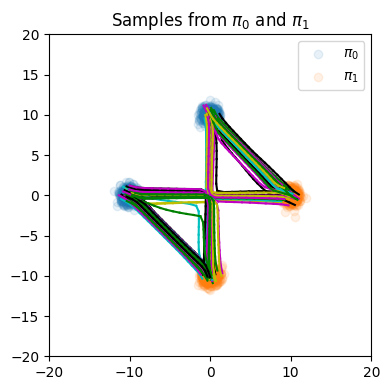

In [35]:
plt.figure(figsize=(4, 4))
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(samples_0[:, 0].cpu().numpy(), samples_0[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_0$')
plt.scatter(samples_1[:, 0].cpu().numpy(), samples_1[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_1$')
plt.legend()


mycolor = ['b', 'r']
color_candidate = ['g', 'c', 'm', 'y', 'k']

sample_num = len(traj1)
this_step = 5
for i in range(sample_num): 
    pointindex = list(range(0, (len(traj1) - 1), this_step)) + [len(traj1) - 1] 
    thiscolor = random.sample(color_candidate, 1)[0]
    for k in range(len(pointindex) - 1):
        plt.plot([traj1[pointindex[k]][i, 0], traj1[pointindex[k + 1]][i, 0]], [traj1[pointindex[k]][i, 1], traj1[pointindex[k + 1]][i, 1]], c=thiscolor) 
        # if(k == 0): 
        #     plt.scatter([traj[pointindex[k]][i, 0]], [traj[pointindex[k]][i, 1]], s = 30, c=mycolor[0])
        # elif(k + 1 == len(pointindex) - 1): 
        #     plt.scatter([traj[pointindex[k + 1]][i, 0]], [traj[pointindex[k + 1]][i, 1]], s = 30, c=mycolor[1])
        # else: 
        #     plt.scatter([traj[pointindex[k]][i, 0]], [traj[pointindex[k]][i, 1]], s = 10, c=thiscolor)
        #     plt.scatter([traj[pointindex[k + 1]][i, 0]], [traj[pointindex[k + 1]][i, 1]], s = 10, c=thiscolor)
plt.tight_layout()
plt.show()

In [30]:
z10 = samples_0.detach().clone()
traj = rectified_flow_1.sample_ode(z0=z10.detach().clone(), N=100)
z11 = traj[-1].detach().clone()
z_pairs = torch.stack([z10, z11], dim=1)
print(z_pairs.shape)

torch.Size([1000, 2, 2])


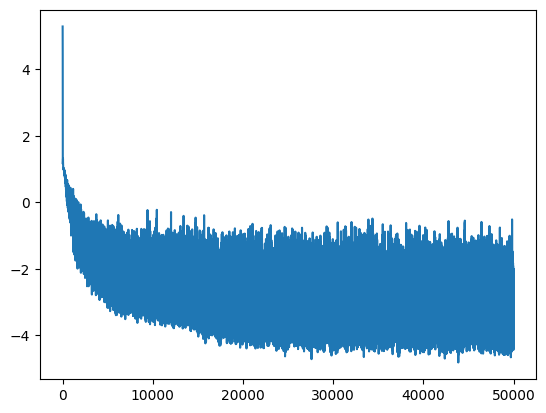

In [31]:
reflow_iterations = 50000

rectified_flow_2 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=100)
import copy 
rectified_flow_2.net = copy.deepcopy(rectified_flow_1) # we fine-tune the model from 1-Rectified Flow for faster training.
optimizer = torch.optim.Adam(rectified_flow_2.model.parameters(), lr=5e-3)

rectified_flow_2, loss_curve = train_rectified_flow(rectified_flow_2, optimizer, z_pairs, batchsize, reflow_iterations)
plt.plot(np.linspace(0, reflow_iterations, reflow_iterations+1), loss_curve[:(reflow_iterations+1)])

In [37]:
traj2 = rectified_flow_2.sample_ode(x_0)

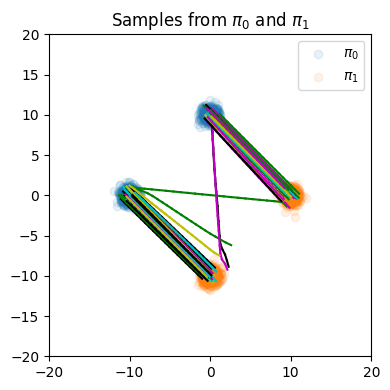

In [38]:
plt.figure(figsize=(4, 4))
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(samples_0[:, 0].cpu().numpy(), samples_0[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_0$')
plt.scatter(samples_1[:, 0].cpu().numpy(), samples_1[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_1$')
plt.legend()


mycolor = ['b', 'r']
color_candidate = ['g', 'c', 'm', 'y', 'k']

sample_num = len(traj2)
this_step = 5
for i in range(sample_num): 
    pointindex = list(range(0, (len(traj2) - 1), this_step)) + [len(traj2) - 1] 
    thiscolor = random.sample(color_candidate, 1)[0]
    for k in range(len(pointindex) - 1):
        plt.plot([traj2[pointindex[k]][i, 0], traj2[pointindex[k + 1]][i, 0]], [traj2[pointindex[k]][i, 1], traj2[pointindex[k + 1]][i, 1]], c=thiscolor)
        # if(k == 0): 
        #     plt.scatter([traj[pointindex[k]][i, 0]], [traj[pointindex[k]][i, 1]], s = 30, c=mycolor[0])
        # elif(k + 1 == len(pointindex) - 1): 
        #     plt.scatter([traj[pointindex[k + 1]][i, 0]], [traj[pointindex[k + 1]][i, 1]], s = 30, c=mycolor[1])
        # else: 
        #     plt.scatter([traj[pointindex[k]][i, 0]], [traj[pointindex[k]][i, 1]], s = 10, c=thiscolor)
        #     plt.scatter([traj[pointindex[k + 1]][i, 0]], [traj[pointindex[k + 1]][i, 1]], s = 10, c=thiscolor)
plt.tight_layout()
plt.show()